In [1]:
# %pip install colorlog

In [1]:
import spTEP_cleaning
import mne
import os
import concurrent.futures
from tqdm import tqdm
import colorlog
import matplotlib.pyplot as plt

# plt.switch_backend("TkAgg")

In [2]:
DATASET_PATH = "./dataset"
FILENAME_TEMPLATE = "TMS-EEG-H_02_S1b_{}_{}.vhdr"

spTEP_filename = os.path.join(DATASET_PATH, FILENAME_TEMPLATE.format("spTEP", "pre"))

spTEP_pre_raw = mne.io.read_raw_brainvision(spTEP_filename, preload=True)
sampling_rate = spTEP_pre_raw.info["sfreq"]
events, event_dict = mne.events_from_annotations(spTEP_pre_raw)
tms_indices = [event[0] for event in events if event[2] == 1]

Extracting parameters from ./dataset/TMS-EEG-H_02_S1b_spTEP_pre.vhdr...
Setting channel info structure...
Reading 0 ... 2696199  =      0.000 ...   539.240 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1']


[2024-05-14 12:14:50,581] - INFO - Removing EOG channels
[2024-05-14 12:14:58,252] - INFO - Interpolating TMS pulse from 0.005 to 0.015 seconds


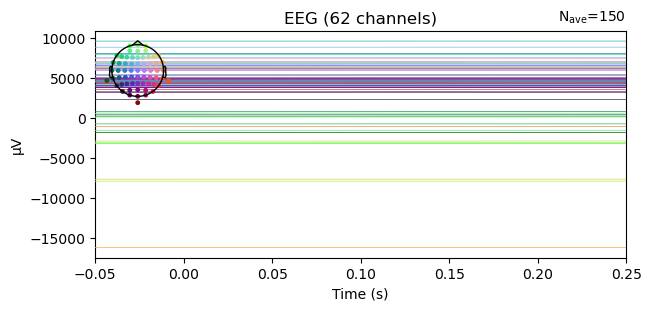

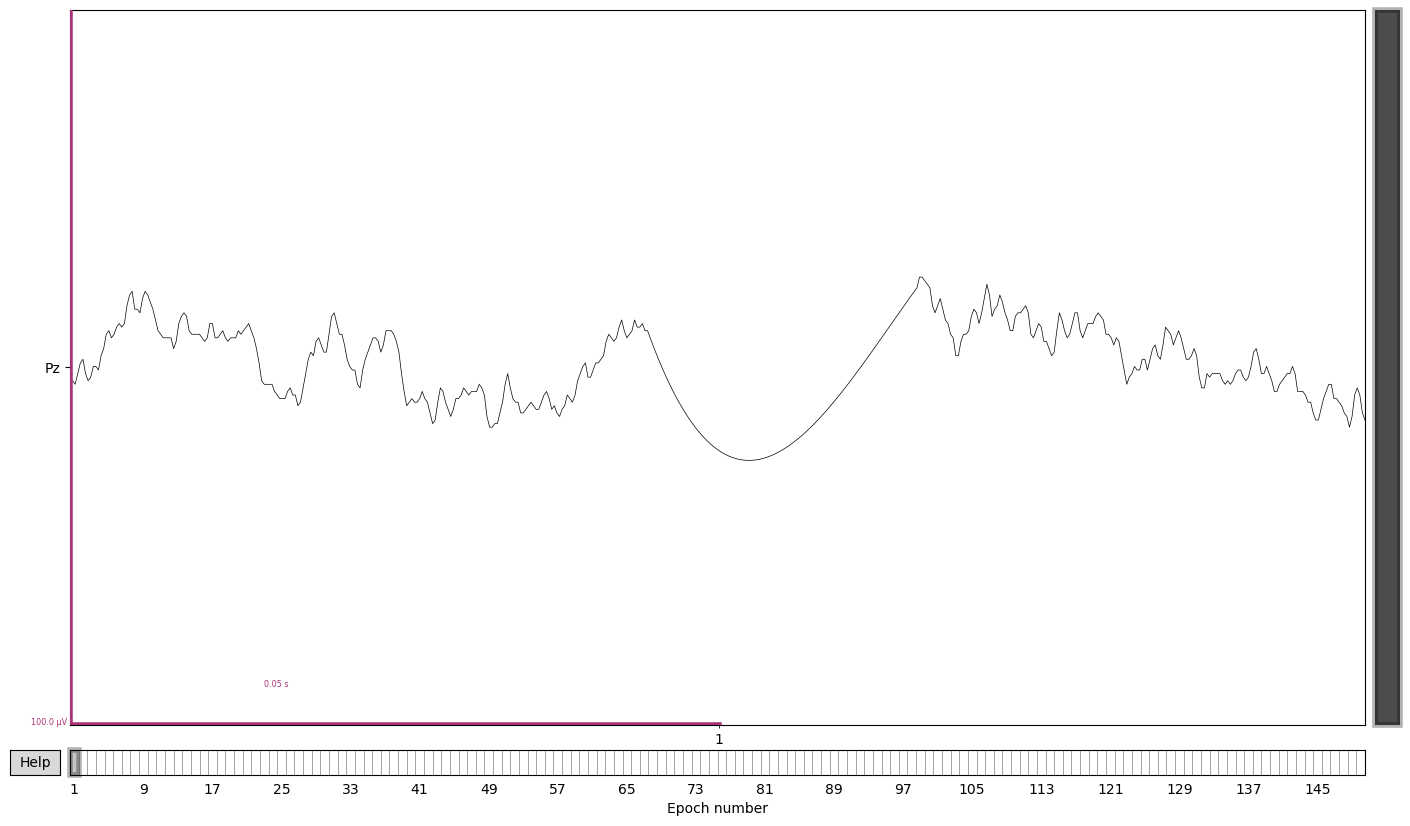

[2024-05-14 12:15:02,104] - INFO - Downsampling to 1000 Hz
[2024-05-14 12:15:20,473] - INFO - Epoching


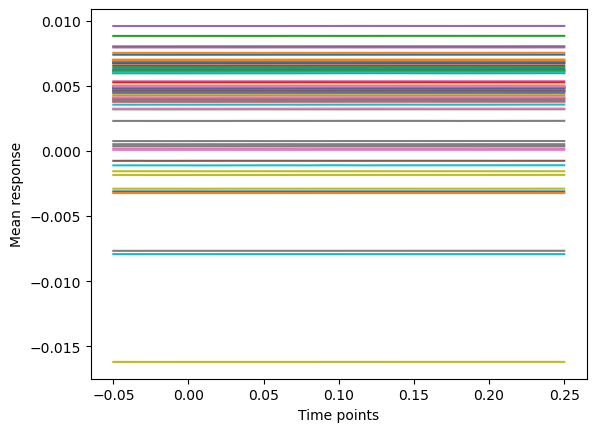

[2024-05-14 12:15:20,643] - INFO - Demeaning


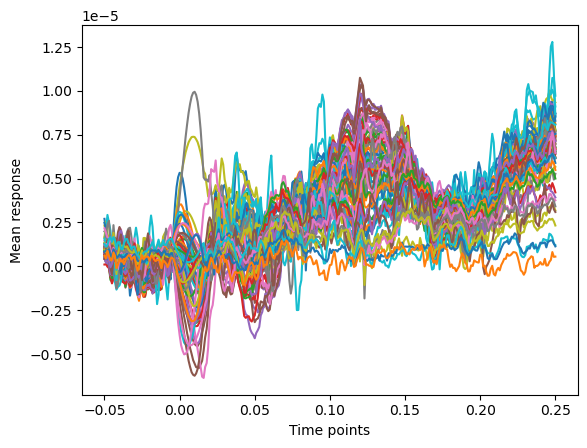

[2024-05-14 12:15:20,847] - INFO - ICA 1 from 0.011 to 0.03 seconds
/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:189: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epoch_data)
/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:193: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  averaged_sources = sources.get_data().mean(axis=0)
[2024-05-14 12:15:29,532] - INFO - Excluding ICA components [8, 12]


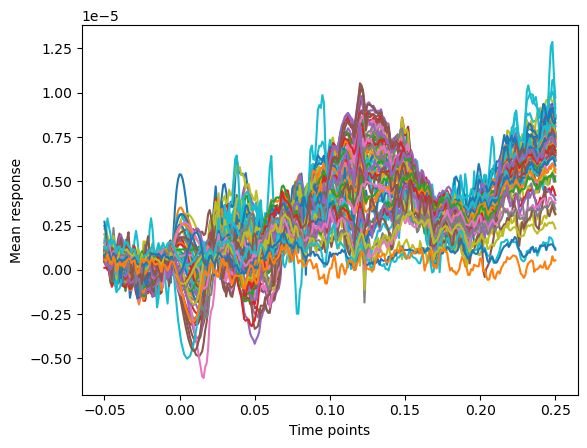

[2024-05-14 12:15:29,973] - INFO - Bandpass 1-100 Hz and notch [50] Hz
/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:219: RuntimeWarning: filter_length (3301) is longer than the signal (2001), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_data.filter(low_freq, high_freq)
/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:223: RuntimeWarning: filter_length (6601) is longer than the signal (2001), distortion is likely. Reduce filter length or filter a longer signal.
  notch_filtered = mne.filter.notch_filter(


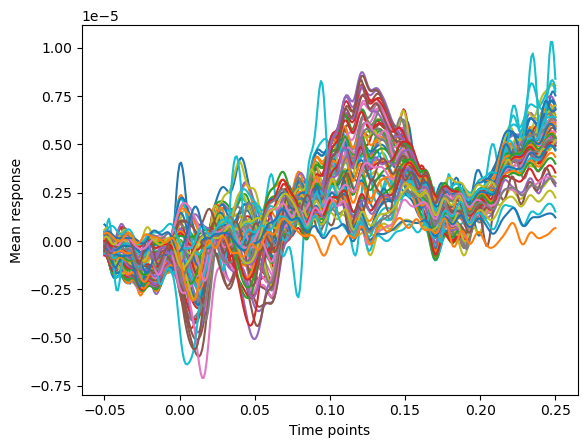

[2024-05-14 12:15:34,327] - INFO - ICA 2
/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:241: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(epoch_data, ica, method="iclabel")
/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:241: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(epoch_data, ica, method="iclabel")


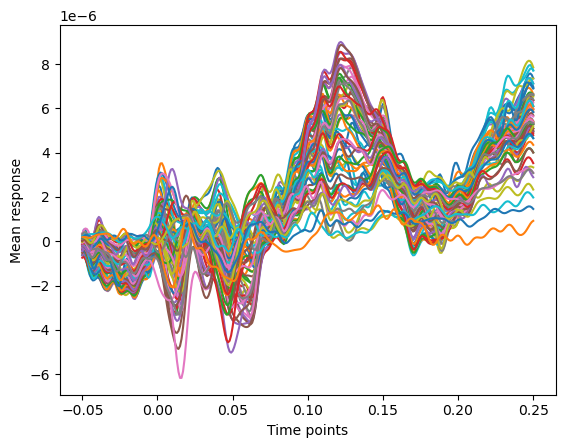

[2024-05-14 12:15:43,715] - INFO - Rereferencing to average


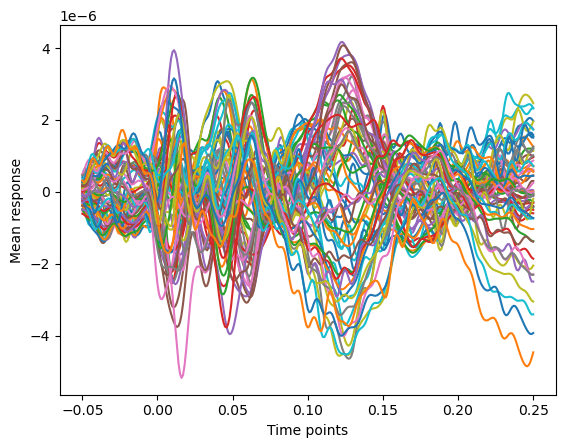

[2024-05-14 12:15:43,985] - INFO - Baseline correction from -0.5 to -0.005 s
[2024-05-14 12:15:44,018] - INFO - Plotting all electrodes


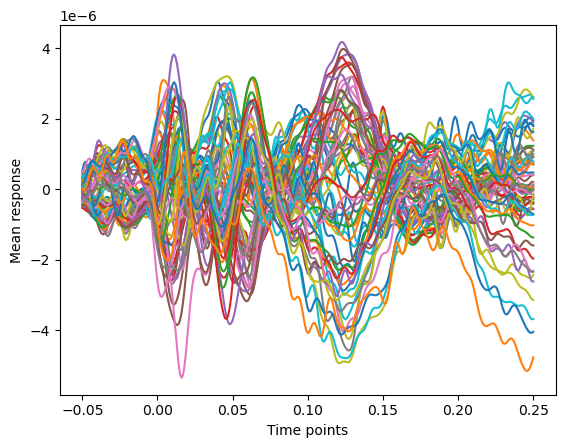

/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:87: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
[2024-05-14 12:15:44,297] - INFO - Difference between GMFP and GMFA
[2024-05-14 12:15:44,298] - INFO - 0.0


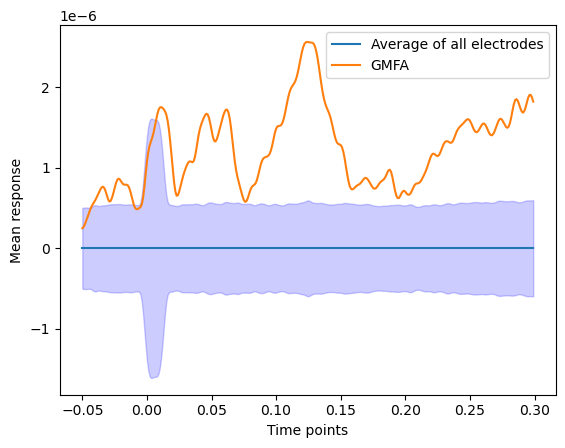

[2024-05-14 12:15:44,375] - INFO - Plotting source electrode(s)


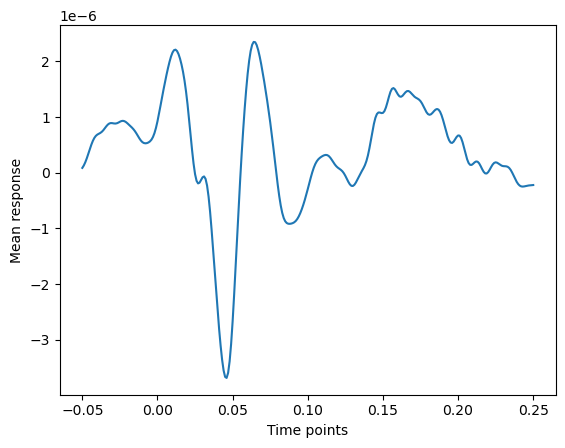

/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:69: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs.pick_channels(electrodes)
/home/tomasgalle/UGent/thesis/tms-research/spTEP_cleaning.py:87: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
[2024-05-14 12:15:44,539] - INFO - Difference between GMFP and GMFA
[2024-05-14 12:15:44,539] - INFO - 0.0


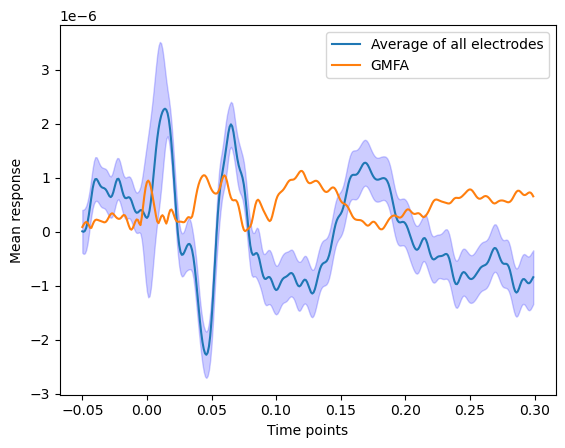

In [3]:
spTEP_cleaning.clean_spTEP(
    spTEP_filename,
    spTEP_pre_raw,
    bad_channels=["TP9"],
    plot_intermediate=True,
    plot_result=True,
    finalplot_electrodes=["F3", "FC5", "FC1"],
    finalplot_end=0.3,
)

In [ ]:
def process_file(file_path):
    raw = mne.io.read_raw_brainvision(file_path, preload=True)

    spTEP_cleaning.clean_spTEP(file_path, raw, plot_result=True, save_result=False)


DATASET_PATH = os.path.join(".", "dataset")

files = [
    os.path.join(DATASET_PATH, file)
    for file in os.listdir(DATASET_PATH)
    if file.endswith(".vhdr") and "spTEP" in file
]

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_file, file) for file in files]
    for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        pass

In [2]:
# load fif file and apply plot_full_average_epoch on the epochs object
epochs = mne.read_epochs("filtered\TMS-EEG-H_02_S1b_spTEP_post_filtered-epo.fif")
spTEP_cleaning.plot_full_average_epoch(epochs)

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_3325705/3524740014.py:2: SyntaxWarning: invalid escape sequence '\T'
  epochs = mne.read_epochs("filtered\TMS-EEG-H_02_S1b_spTEP_post_filtered-epo.fif")
/tmp/ipykernel_3325705/3524740014.py:2: SyntaxWarning: invalid escape sequence '\T'
  epochs = mne.read_epochs("filtered\TMS-EEG-H_02_S1b_spTEP_post_filtered-epo.fif")


NameError: name 'mne' is not defined